# Advanced Lane Lines
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

# Camera Calibration

## Types of distortion
### Radial Distortion
_This creates an effect that distorts the edges of images, so that lines or objects appear more or less curved than they actually are_
#### Coefficients
There are three coefficients for radial distortion, **k1**, **k2**, **k3**
### Tangential Distortion
_This occurs when a camera’s lens is not aligned perfectly parallel to the imaging plane, where the camera film or sensor is._

## Chessboard Calibration Steps
### Find Chessboard Corners
Find corners using `cv2.findChessboardCorners()`

Example:
```python
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 8
ny = 6

# Make a list of calibration images
fname = 'calibration_test.png'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
```

In [2]:
def compute_camera_matrix(calibration_dir, nx, ny, plot=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for file in os.listdir("{}/".format(calibration_dir)):
        image = mpimg.imread('{}/{}'.format(calibration_dir, file))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #printing out some stats and plotting
        print(file, 'This image is:', type(image), 'with dimensions:', image.shape)
        img_size = (image.shape[1], image.shape[0])
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            if plot:
                cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(image)
            
    # Do camera calibration given object points and image points
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


In [3]:
def undistort_image(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

def undistort_images(input_dir, output_dir, mtx, dist):
    for file in os.listdir("{}/".format(input_dir)):
        input_file = '{}/{}'.format(input_dir, file)
        output_file = '{}/{}'.format(output_dir, file)
        print("Undistoring {} and saving to {}".format(input_file, output_file))
        image = mpimg.imread(input_file)
        dst = undistort_image(image, mtx, dist)
        cv2.imwrite(output_file, dst)

#undistort_images("test_images", "test_images_undist", mtx, dist)

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = img
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magxy = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_mag = np.uint8(255*magxy/np.max(magxy))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = img
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    direction = np.arctan2(absy, absx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

def hls_select(img, s_thresh=(0, 255), l_thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    binary_output = np.zeros_like(S)
    binary_output[(S > s_thresh[0]) & (S <= s_thresh[1]) & (L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    return binary_output

def transform_perspective(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)



In [5]:
def get_nonzero_pixels_in_rectangle(x_low, x_high, y_low, y_high, nonzerox, nonzeroy):
    results = []
    for idx in range(len(nonzerox)):
        x = nonzerox[idx]
        y = nonzeroy[idx]
        if x >= x_low and x < x_high and y >= y_low and y < y_high:
            results.append(int(idx))
    return results

def find_new_x_position(good_indices, positions):
    mean_val = 0;
    for idx in good_indices:
        mean_val = mean_val + positions[idx]
    mean_val = mean_val / len(good_indices)
    return int(mean_val)

def find_lane_pixels(binary_warped):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # If max of histogram is below this value, use full image
    hist_min = 100
    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Take a histogram of full image (as a fallback)
    histogram_full = np.sum(binary_warped[:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    if np.max(histogram[:midpoint]) < hist_min:
        leftx_base = np.argmax(histogram_full[:midpoint])
    else:
        leftx_base = np.argmax(histogram[:midpoint])
        
    if np.max(histogram[midpoint:]) < hist_min:
        rightx_base = np.argmax(histogram_full[midpoint:]) + midpoint
    else:
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = get_nonzero_pixels_in_rectangle(win_xleft_low, win_xleft_high, win_y_low, win_y_high, nonzerox, nonzeroy)
        good_right_inds = get_nonzero_pixels_in_rectangle(win_xright_low, win_xright_high, win_y_low, win_y_high, nonzerox, nonzeroy)
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = find_new_x_position(good_left_inds, nonzerox)
        if len(good_right_inds) > minpix:
            rightx_current = find_new_x_position(good_right_inds, nonzerox)
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds).astype(int)
        right_lane_inds = np.concatenate(right_lane_inds).astype(int)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def get_curvature(y, fit_poly):
    A = fit_poly[0]
    B = fit_poly[1]
    R = ((1 + (2*A*y + B)**2)**(3/2)) / np.abs(2*A)
    return R

def fit_polynomial(binary_warped, xm_per_pix, ym_per_pix):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Find our best fit in pixel space
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ## Visualization ##
    # Colors in the left and right lane regions
#     annotated_img = np.copy(out_img)
    
#     annotated_img[lefty, leftx] = [255, 0, 0]
#     annotated_img[righty, rightx] = [0, 0, 255]
#     cv2.imwrite("annotated_test.jpg", annotated_img)
    
    # Scale to meters
    leftx = leftx * xm_per_pix
    rightx = rightx * xm_per_pix
    
    lefty = lefty * ym_per_pix
    righty = righty * ym_per_pix

    # Find our best fit in meters
    left_fit_m = np.polyfit(lefty, leftx, 2)
    right_fit_m = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    y_eval = np.max(ploty)

    return ploty, left_fit_m, right_fit_m, left_fitx, right_fitx, out_img



In [6]:
# Camera Calibration Parameters
calibration_dir = "camera_cal"
nx = 9
ny = 6

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
ret, mtx, dist, rvecs, tvecs = compute_camera_matrix(calibration_dir, nx, ny)



calibration14.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration19.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration6.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration15.jpg This image is: <class 'numpy.ndarray'> with dimensions: (721, 1281, 3)
calibration10.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration9.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration16.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration20.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration4.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration11.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration5.jpg This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calibration3.jpg This ima

Processing test_images/test2.jpg
Processing test_images/test4.jpg
Processing test_images/test5.jpg
Processing test_images/straight_lines1.jpg
Processing test_images/test6.jpg
Processing test_images/test1.jpg
Processing test_images/test3.jpg
Processing test_images/straight_lines2.jpg


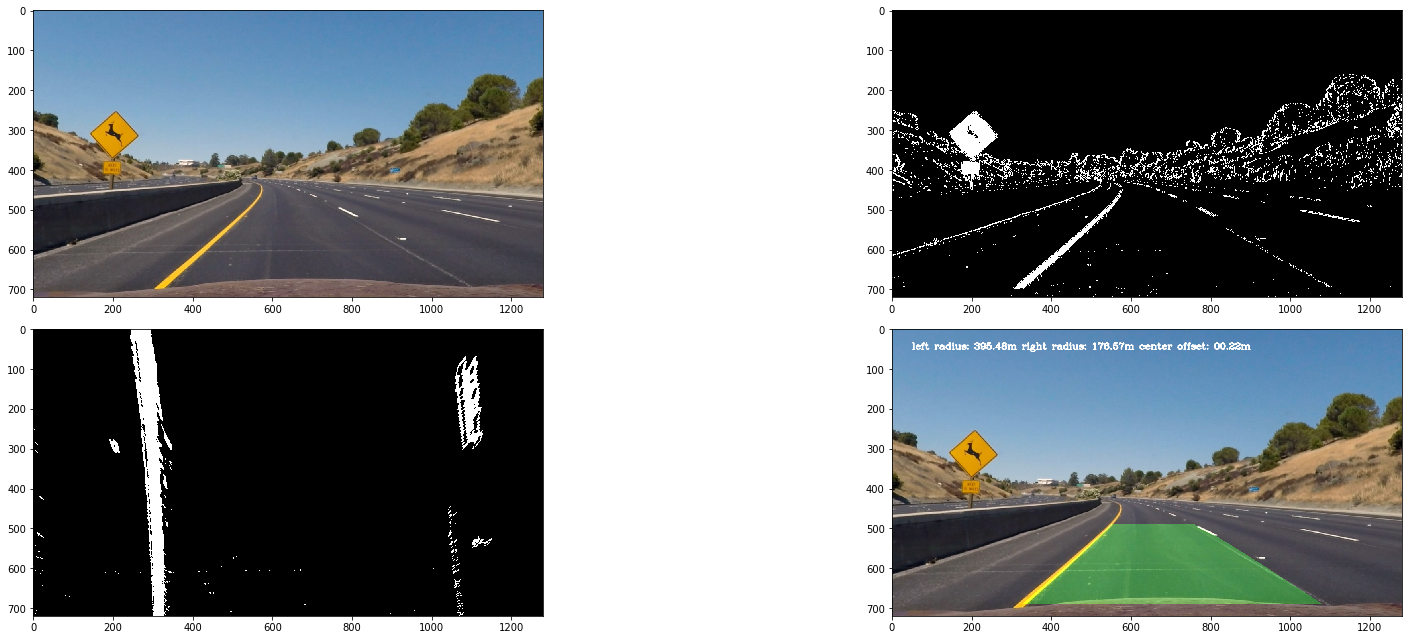

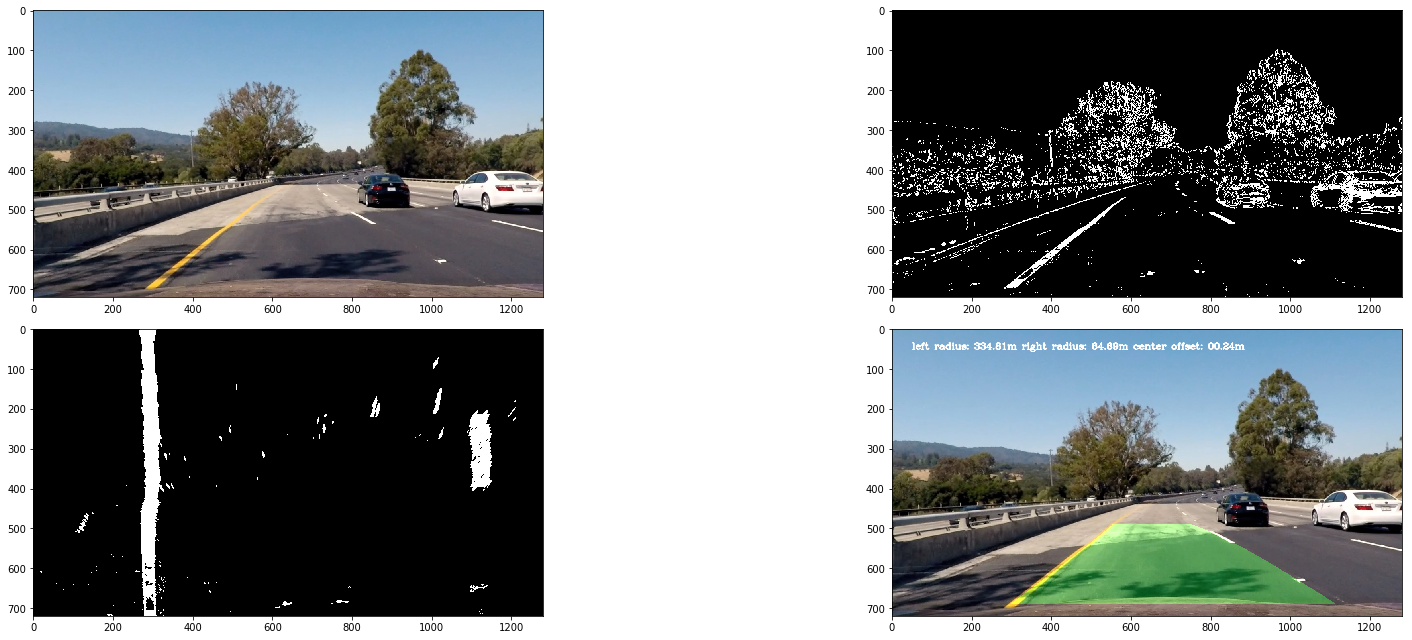

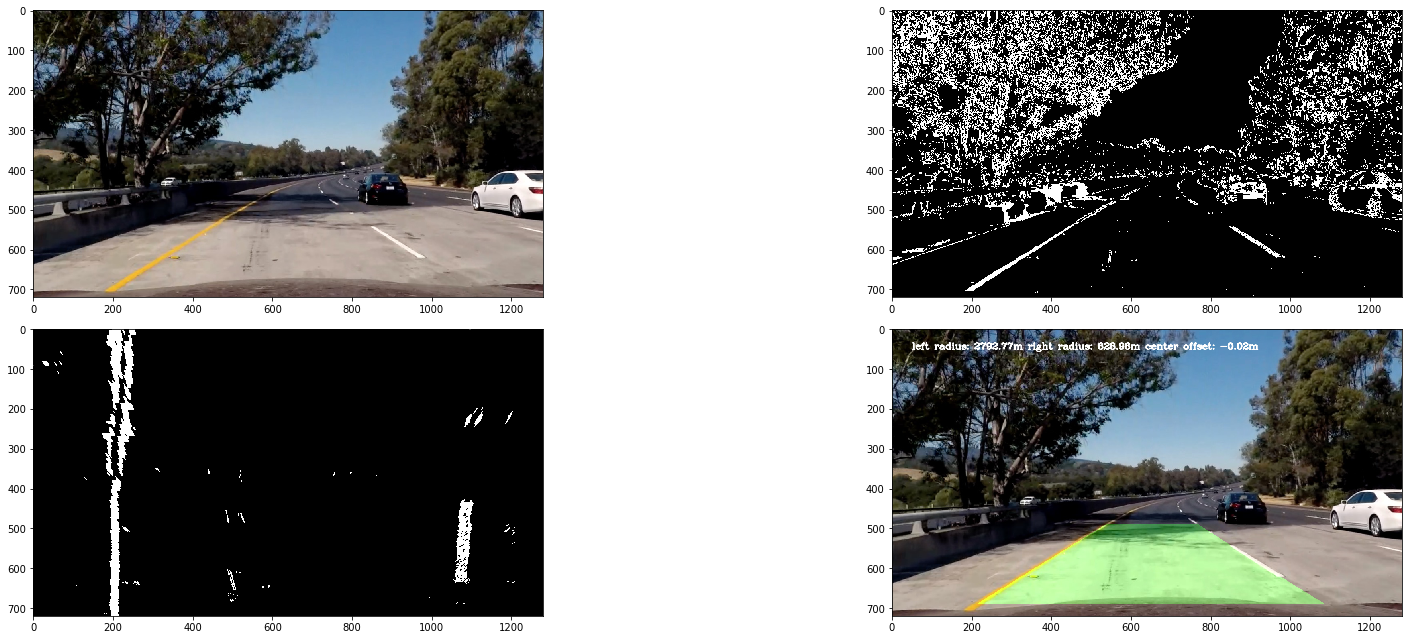

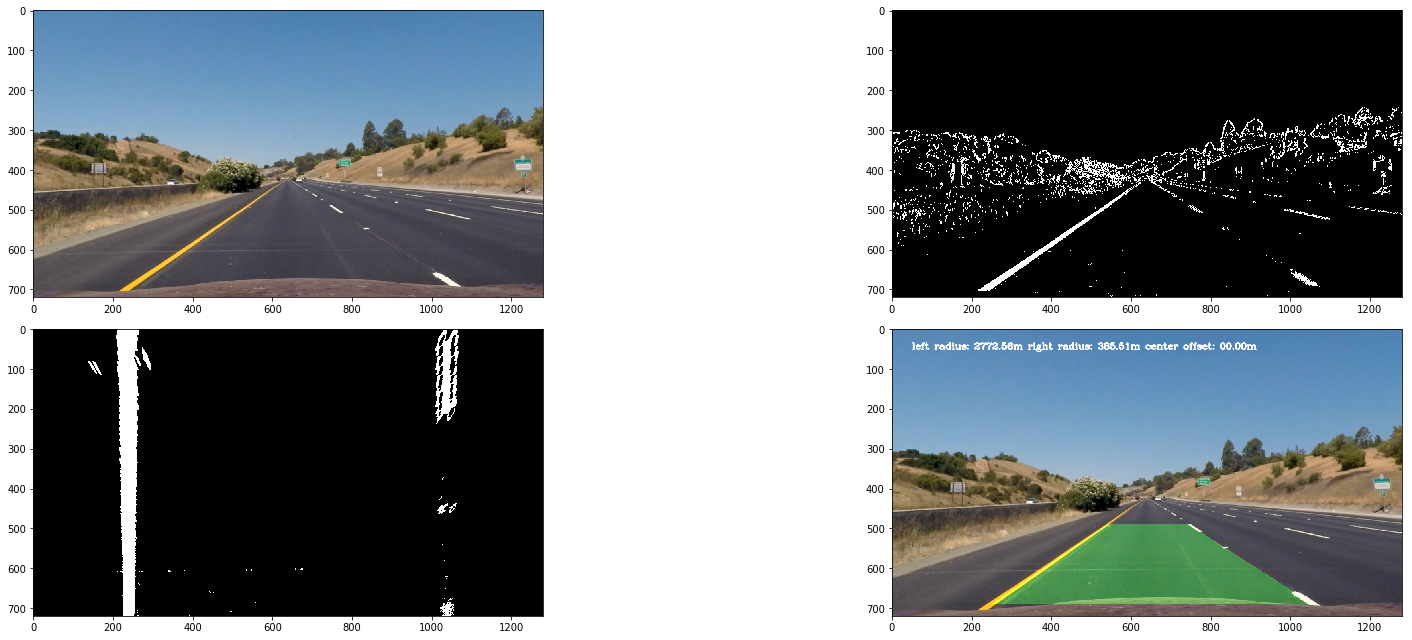

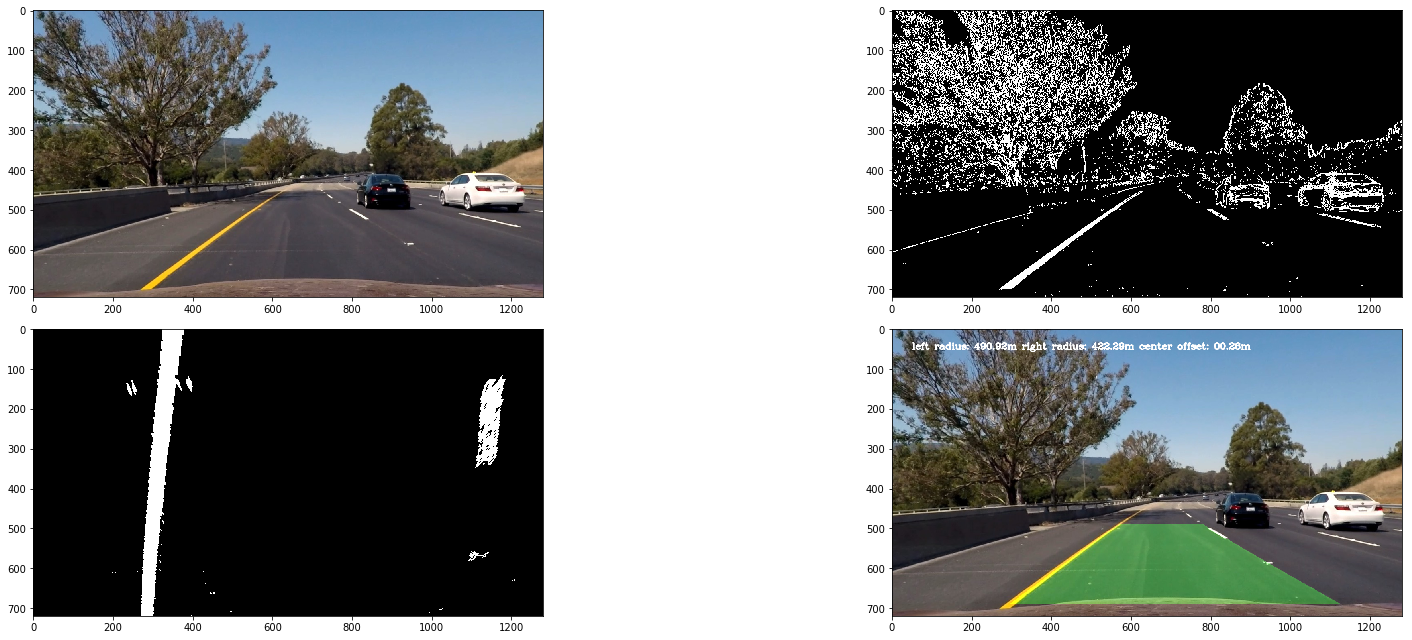

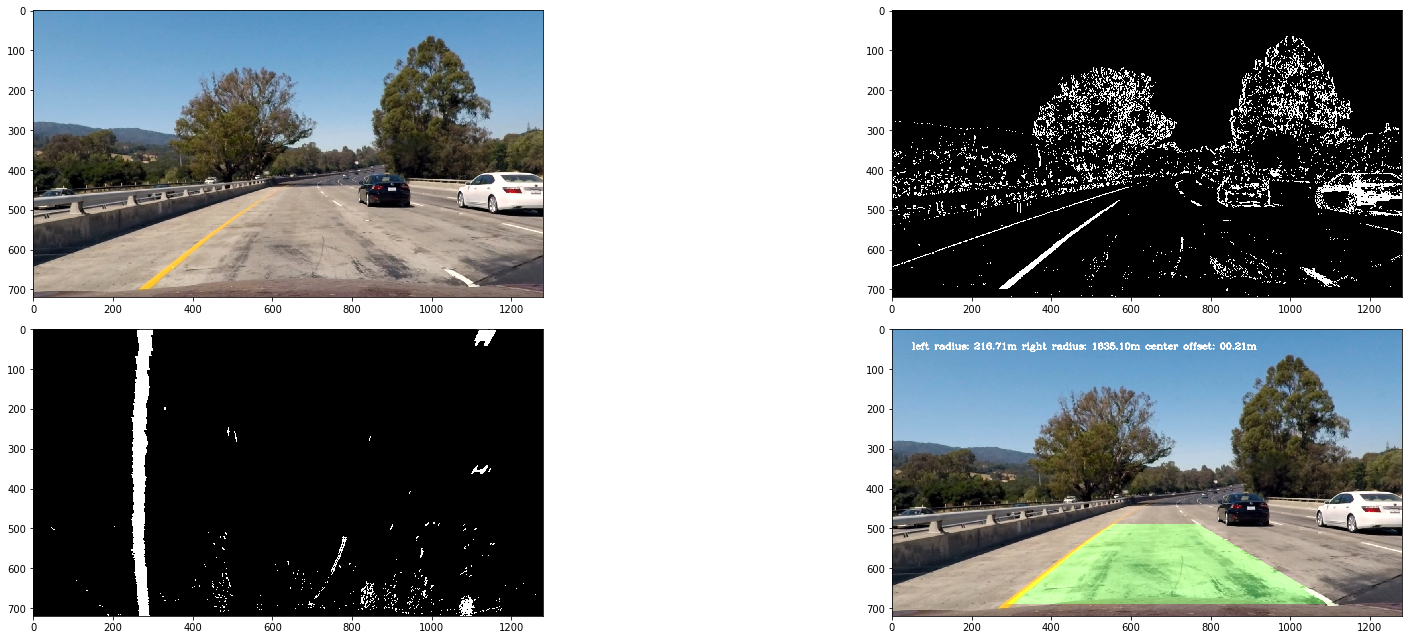

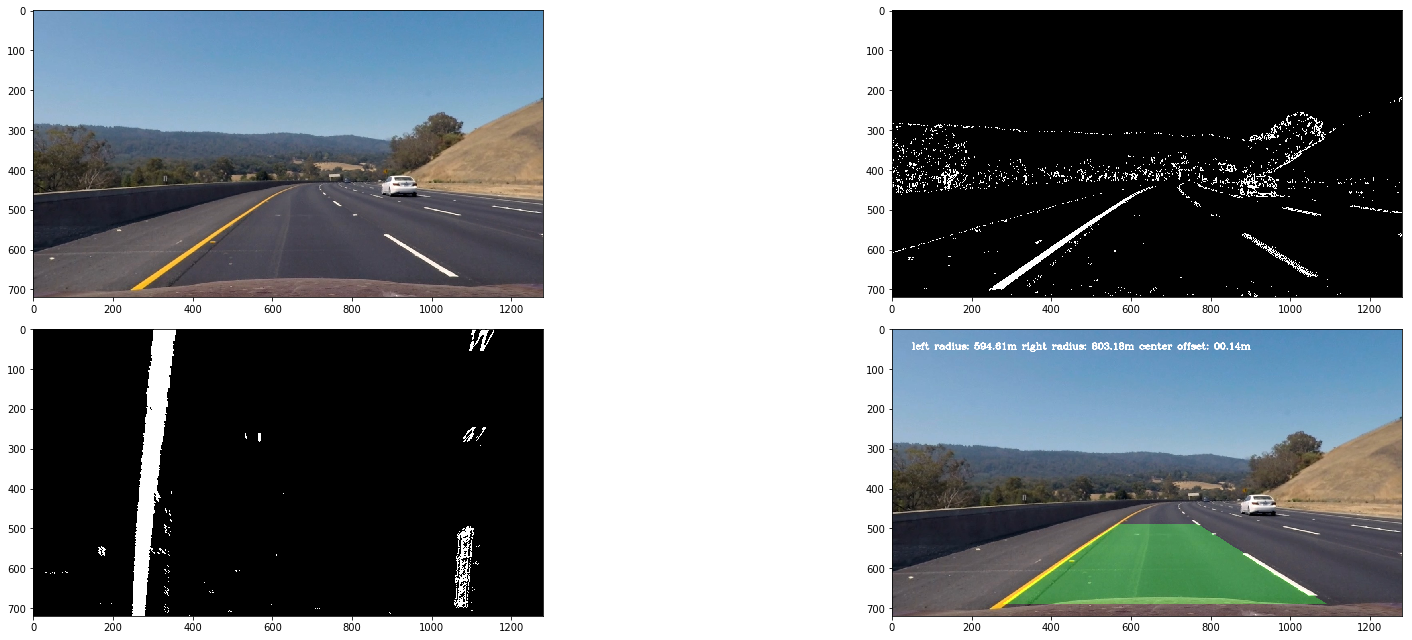

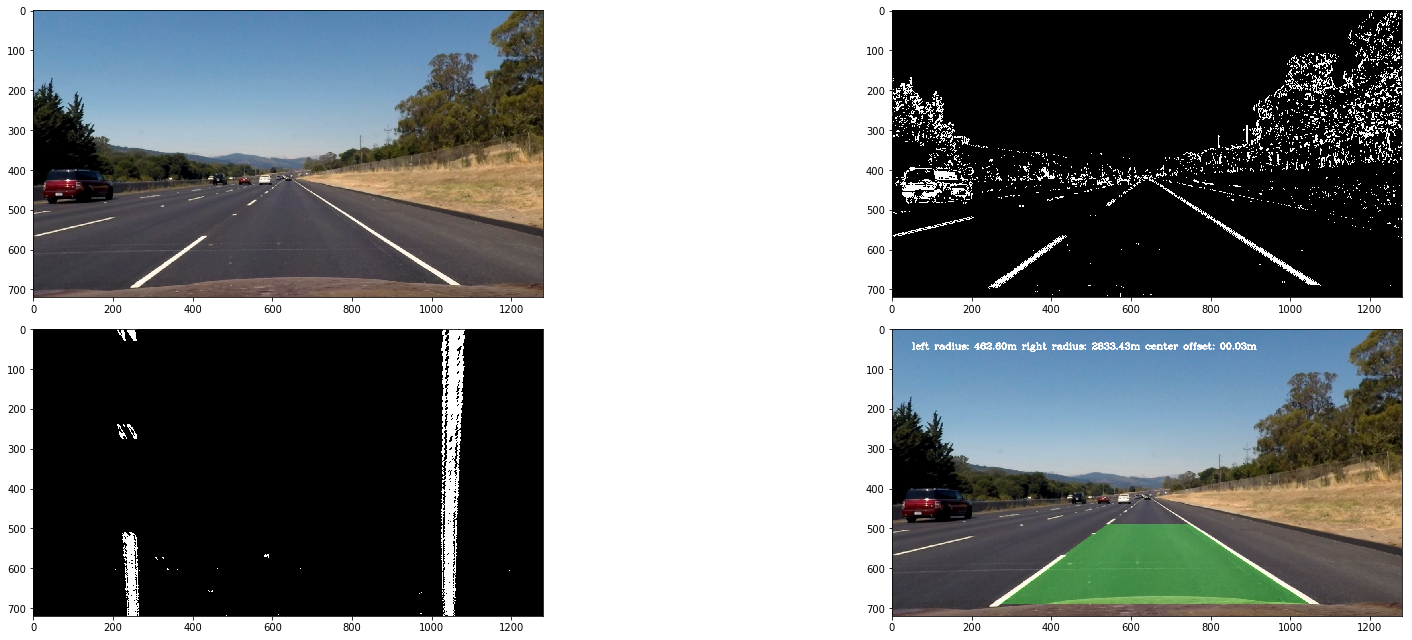

In [7]:
# Perspective Transform Parameters
pt_src = np.float32(
    [[248, 691],
    [529, 498],
    [760, 498],
    [1060, 691]])

dst_width = 800
dst_height = 600
origin_x = (1280 / 2) - (dst_width / 2)
origin_y = 720

pt_dst = np.float32(
    [[origin_x, origin_y],
    [origin_x, origin_y-dst_height],
    [origin_x+dst_width, origin_y-dst_height],
    [origin_x+dst_width, origin_y]]
)

# Camera image scaling parameters
xm_per_pix = (3.6576 / dst_width) # 12 foot lane width
ym_per_pix = (9.144 / dst_height) # 30 foot gap in between dashed lanes

# xm_per_pix = 1.0
# ym_per_pix = 1.0

# Color transforms / gradient parameters
gradx_thresh = (20, 100)
grady_thresh = (0, 255)
direction_window = 0.3
direction_center = np.pi / 4
direction_thresh = (direction_center - direction_window, direction_center + direction_window)
mag_threshold = (1, 255)
s_threshold = (170, 255)
l_threshold = (0, 255)
gradxy_ksize = 3
ksize = 3

def calculate_center_offset(left_fix_m, right_fit_m, y_eval_m, frame_width_m):
    left_lane_offset = left_fix_m[0]*y_eval_m**2 + left_fix_m[1]*y_eval_m + left_fix_m[2]
    right_lane_offset = right_fit_m[0]*y_eval_m**2 + right_fit_m[1]*y_eval_m + right_fit_m[2]
    center_of_lanes = left_lane_offset + (right_lane_offset - left_lane_offset) / 2
    center_of_frame = (frame_width_m / 2)
    return center_of_lanes - center_of_frame

def run_pipeline(image, axs=None, output_prefix=None, output_directory=None):
    # Apply a distortion correction to raw images.
    image = undistort_image(image, mtx, dist)
    undist = np.copy(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if axs is not None:
        axs[0][0].imshow(image)
        
    if output_directory is not None and output_prefix is not None:
        cv2.imwrite("{}/{}_{}".format(output_directory, output_prefix, "undistort.jpg"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    # Use color transforms, gradients, etc., to create a thresholded binary image.
    s_binary = hls_select(image, s_thresh=s_threshold, l_thresh=l_threshold)
        
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=gradxy_ksize, thresh_min=gradx_thresh[0], thresh_max=gradx_thresh[1])
    
    image = np.zeros_like(s_binary)
    image[(s_binary == 1) | (gradx == 1)] = 1 

    if axs is not None:
        axs[0][1].imshow(image, cmap='gray')
        
    if output_directory is not None and output_prefix is not None:
        cv2.imwrite("{}/{}_{}".format(output_directory, output_prefix, "binary_threshold.jpg"), cv2.cvtColor(image*255, cv2.COLOR_GRAY2BGR))

    # Apply a perspective transform to rectify binary image ("birds-eye view").
    image = transform_perspective(image, pt_src, pt_dst)
    
    if axs is not None:
        axs[1][0].imshow(image, cmap='gray')
        
    if output_directory is not None and output_prefix is not None:
        cv2.imwrite("{}/{}_{}".format(output_directory, output_prefix, "warped_perspective.jpg"), cv2.cvtColor(image*255, cv2.COLOR_GRAY2BGR))

    # Detect lane pixels and fit to find the lane boundary.    
    # Results are in meters
    ploty, left_fit, right_fit, left_fitx, right_fitx, out_img = fit_polynomial(image, xm_per_pix, ym_per_pix)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the detected lane boundaries back onto the original image.
    newwarp = transform_perspective(color_warp, pt_dst, pt_src) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


    # Determine the curvature of the lane and vehicle position with respect to center.
    y_eval_m = np.max(ploty)*ym_per_pix
    left_radius_m = get_curvature(y_eval_m, left_fit)
    right_radius_m = get_curvature(y_eval_m, right_fit)
    
    frame_width_m = image.shape[1] * xm_per_pix
    center_offset = calculate_center_offset(left_fit, right_fit, y_eval_m, frame_width_m)
    result_string = "left radius: {:05.2f}m right radius: {:05.2f}m center offset: {:05.2f}m".format(left_radius_m, right_radius_m, center_offset)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    cv2.putText(result, result_string, (50,50), cv2.FONT_HERSHEY_COMPLEX, 0.75, (255,255,255),2,cv2.LINE_AA)
    if axs is not None:
        axs[1][1].imshow(result)
        
    if output_directory is not None and output_prefix is not None:
        cv2.imwrite("{}/{}_{}".format(output_directory, output_prefix, "final_result.jpg"), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    return result
    
    
def run_pipeline_on_test_images():
    input_directory="test_images"
    for file in os.listdir(input_directory):
        f, axs = plt.subplots(2, 2, figsize=(24, 9))
        f.tight_layout()
        input_file = "{}/{}".format(input_directory, file)
        print("Processing {}".format(input_file))
        image = mpimg.imread(input_file)
        run_pipeline(image, axs, file.split('.')[0], "output_images")


run_pipeline_on_test_images()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(input_file, output_file):
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(input_file)
    video_clip = clip1.fl_image(run_pipeline) #NOTE: this function expects color images!!
    %time video_clip.write_videofile(output_file, audio=False)
    
process_video("project_video.mp4", "project_video_output.mp4")